# Project 3 - Regression


# 1.0 Introduction: The Problem and Dataset

In this project, I will explore and predict **RuneScape Grand Exchange item prices** using regression analysis.  
The goal is to understand **daily price fluctuations** and potentially forecast **future price changes** for in-game marketplace items.

The dataset comes from [Kaggle: RuneScape Grand Exchange Data](https://www.kaggle.com/datasets/aparoski/runescape-grand-exchange-data).  
It includes:

- `id` / `Name_ID`: Unique identifier for each item  
- `Name`: Item name  
- `price`: Average daily price  
- `volume`: Total trade volume  
- `date`: Date of the observation  
- `Name_URL`: URL link to the item on the Grand Exchange  

**Objective:** For this project I will use regression to try and Predict daily **price changes** based on item trade volume, previous price trends, and other relevant patterns.


# Section 2.0 What Is Regression and How Does It Work?

Regression is a type of supervised machine learning method used to model the relationship between a dependent variable (target) and one or more independent variables (features).

### Linear Regression

Linear regression assumes a linear relationship between variables:

\[
y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon
\]

Where:
- \(y\) = predicted target (price or price change)
- \(x_i\) = features (volume, lagged price, etc.)
- \(\beta_i\) = model coefficients (weights)
- \(\epsilon\) = error term

We minimize **Mean Squared Error (MSE)**:

\[
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^2
\]

In this project linear regression helps quantify how trade volume and prior prices influence next-day price changes.


# Section 3.0 Data Understanding

Before modeling, we’ll combine the datasets, inspect their structure, and visualize key patterns to understand the RuneScape economy.


   Unnamed: 0  id  price  volume                date  Name_ID        Name  \
0     7340596   2    188     NaN 2008-05-20 19:00:00        2  Cannonball   
1     7340597   2    186     NaN 2008-05-21 19:00:00        2  Cannonball   
2     7340598   2    186     NaN 2008-05-22 19:00:00        2  Cannonball   
3     7340599   2    184     NaN 2008-05-23 19:00:00        2  Cannonball   
4     7340600   2    184     NaN 2008-05-24 19:00:00        2  Cannonball   

                                            Name_URL  
0  https://secure.runescape.com/m=itemdb_rs/Canno...  
1  https://secure.runescape.com/m=itemdb_rs/Canno...  
2  https://secure.runescape.com/m=itemdb_rs/Canno...  
3  https://secure.runescape.com/m=itemdb_rs/Canno...  
4  https://secure.runescape.com/m=itemdb_rs/Canno...  
Shape: (26246910, 8)
Merged dataset saved as Runescape_Merged.csv


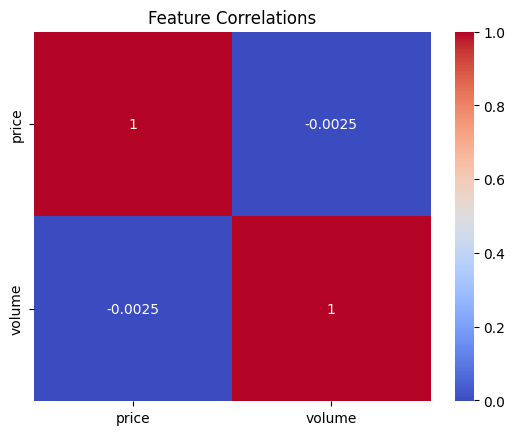

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Load datasets
names = pd.read_csv("Runescape_Item_Names.csv")
prices = pd.read_csv("Runescape_Item_Prices.csv")
urls = pd.read_csv("Runescape_Item_URLS.csv")


names.columns = names.columns.str.strip()
prices.columns = prices.columns.str.strip()
urls.columns = urls.columns.str.strip()

#Merge datasets 
merged = prices.merge(names, left_on='id', right_on='Name_ID', how='left')
merged = merged.merge(urls, on='Name_ID', how='left')

# Drop unnecessary columns - the # is just an index column
if '#' in merged.columns:
    merged = merged.drop(columns=['#'])

# Convert date to datetime
merged['date'] = pd.to_datetime(merged['date'], errors='coerce')

# Sort data ---
merged = merged.sort_values(by=['id', 'date']).reset_index(drop=True)

print(merged.head())
print("Shape:", merged.shape)

#Save merged dataset 
merged.to_csv("Runescape_Merged.csv", index=False)
print("Merged dataset saved as Runescape_Merged.csv")

# Summary statistics 
merged.describe()

# --- Correlation matrix ---
sns.heatmap(merged[['price', 'volume']].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()


# 3.1 Data Pre-processing

Steps:
- Handle missing values  
- Create a feature for daily price change  
- Choose features for initial regression  


In [11]:
# Handle missing values
merged = merged.dropna(subset=['price', 'volume', 'date'])

# Compute daily price change
merged['price_change'] = merged.groupby('id')['price'].diff()

# Drop NaNs from first diff
merged = merged.dropna(subset=['price_change'])

# Select initial features
features = ['volume']
target = 'price_change'

print("Final dataset ready for modeling:", merged[features + [target]].head())


Final dataset ready for modeling:          volume  price_change
559  44300000.0           0.0
560  46200000.0           3.0
561  48200000.0           0.0
562  50100000.0           5.0
563  52000000.0           0.0


# 4.0 Experiment 1: Modeling

We'll now train a simple Linear Regression model using scikit-learn.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = merged[features]
y = merged[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = LinearRegression()
model1.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


# 4.1 Experiment 1: Evaluation

We’ll use Gradient Boost to evaluate model performance with the dataset.


Experiment 1b Results (Gradient Boosting with Lag + Rolling):
  RMSE (log space): 0.0518
  RMSE (price space): 1,315,937,145.72
  R² Score: 0.9998

Feature Importances:
         Feature  Importance
1     prev_price    0.998728
2  rolling_avg_7    0.001272
0         volume    0.000000


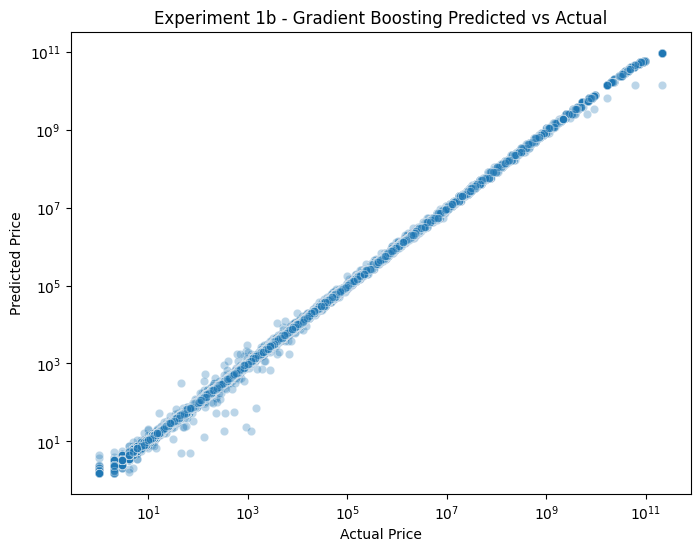

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


#  Feature engineering 
merged['prev_price'] = merged.groupby('id')['price'].shift(1)
merged['rolling_avg_7'] = merged.groupby('id')['price'].transform(lambda x: x.rolling(7).mean())
merged = merged.dropna(subset=['prev_price', 'rolling_avg_7'])

# Log-transform target
merged['log_price'] = np.log1p(merged['price'])

# Features
features = ['volume', 'prev_price', 'rolling_avg_7']
target = 'log_price'

X = merged[features]
y = merged[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42)
gbr_model.fit(X_train, y_train)

# Predictions
y_pred_log = gbr_model.predict(X_test)
y_pred_price = np.expm1(y_pred_log)
y_test_price = np.expm1(y_test)

# Evaluation
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
rmse_price = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
r2 = r2_score(y_test, y_pred_log)

print("Experiment 1b Results (Gradient Boosting with Lag + Rolling):")
print(f"  RMSE (log space): {rmse_log:.4f}")
print(f"  RMSE (price space): {rmse_price:,.2f}")
print(f"  R² Score: {r2:.4f}")

# Feature importance
feat_imp = pd.DataFrame({
    'Feature': features,
    'Importance': gbr_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(feat_imp)

# Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_price, y=y_pred_price, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Experiment 1b - Gradient Boosting Predicted vs Actual")
plt.show()


# 4.0 Experiment 2

We'll use our features to from experiment one of:
- Previous day’s price (`prev_price`)
- Rolling 7-day average price (`rolling_avg_7`)

But now using the Support Vector Regression. This should better capture time-based trends.


Experiment 2 Results (SVR):
  RMSE (log space): 3.3145
  RMSE (price space): 49,434,168,897.71
  R² Score: 0.2793

Feature contributions are not directly available for SVR with RBF kernel.
You can use SHAP or permutation importance for interpretability if needed.


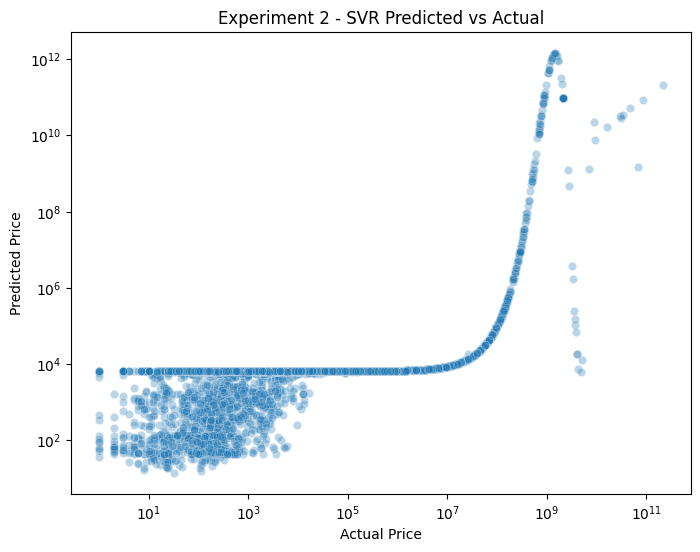

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


# Feature engineering: lag + rolling average 
merged['prev_price'] = merged.groupby('id')['price'].shift(1)
merged['rolling_avg_7'] = merged.groupby('id')['price'].transform(lambda x: x.rolling(7).mean())
merged = merged.dropna(subset=['prev_price', 'rolling_avg_7'])

# Log-transform target
merged['log_price'] = np.log1p(merged['price'])

features = ['volume', 'prev_price', 'rolling_avg_7']
target = 'log_price'

X = merged[features]
y = merged[target]

# --- Sample data for SVR (SVR is slow on large datasets) ---
sample_size = 50000  # adjust based on RAM
if len(merged) > sample_size:
    sample_indices = np.random.choice(len(merged), size=sample_size, replace=False)
    X = X.iloc[sample_indices]
    y = y.iloc[sample_indices]

# --- Standardize features (SVR performs better with scaled data) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- SVR Model ---
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
svr_model.fit(X_train, y_train)

# --- Predictions ---
y_pred_log = svr_model.predict(X_test)
y_pred_price = np.expm1(y_pred_log)
y_test_price = np.expm1(y_test)

# --- Evaluation ---
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
rmse_price = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
r2 = r2_score(y_test, y_pred_log)

print("Experiment 2 Results (SVR):")
print(f"  RMSE (log space): {rmse_log:.4f}")
print(f"  RMSE (price space): {rmse_price:,.2f}")
print(f"  R² Score: {r2:.4f}")

# --- Feature importance (approximation using coefficients is tricky for SVR) ---
print("\nFeature contributions are not directly available for SVR with RBF kernel.")
print("You can use SHAP or permutation importance for interpretability if needed.")

# --- Visualization: Predicted vs Actual ---
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_price, y=y_pred_price, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Experiment 2 - SVR Predicted vs Actual")
plt.show()

# 5.0 Experiment 3

We'll test a Random Forest model which is a regressor to handle nonlinear price relationships and interactions between variables.


Experiment 3 Results (Random Forest):
  RMSE (log space): 0.0291
  RMSE (price space): 31,268,219.29
  R² Score: 0.9999

Feature Importances:
         Feature  Importance
1     prev_price    0.895583
2  rolling_avg_7    0.104415
0         volume    0.000002


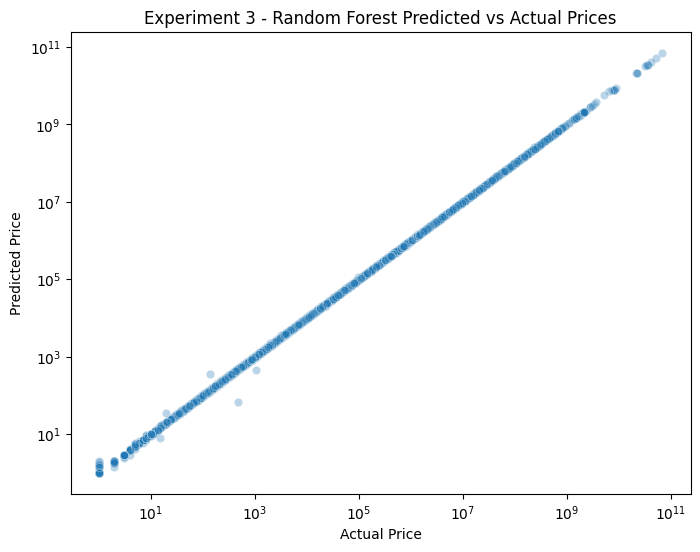

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare dataset (similar to Experiment 2)

# Create lag and rolling average features
merged['prev_price'] = merged.groupby('id')['price'].shift(1)
merged['rolling_avg_7'] = merged.groupby('id')['price'].transform(lambda x: x.rolling(7).mean())

# Drop rows with missing lag/rolling values
merged = merged.dropna(subset=['prev_price', 'rolling_avg_7'])

# Log-transform price
merged['log_price'] = np.log1p(merged['price'])

# Features and target
features3 = ['volume', 'prev_price', 'rolling_avg_7']
target3 = 'log_price'

X = merged[features3]
y = merged[target3]

#  Reduce dataset size for speed 
sample_size = 50000  # adjust based on your RAM
if len(merged) > sample_size:
    sample_indices = np.random.choice(len(merged), size=sample_size, replace=False)
    X = X.iloc[sample_indices]
    y = y.iloc[sample_indices]

# Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=50,   # fewer trees = faster
    max_depth=10,      # limit depth = faster and avoids overfitting
    n_jobs=-1,         # use all CPU cores
    random_state=42
)
rf_model.fit(X_train, y_train)

# Make predictions 
y_pred_log = rf_model.predict(X_test)

# Convert back to original price scale
y_pred_price = np.expm1(y_pred_log)
y_test_price = np.expm1(y_test)

# Evaluation
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
rmse_price = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
r2 = r2_score(y_test, y_pred_log)

print("Experiment 3 Results (Random Forest):")
print(f"  RMSE (log space): {rmse_log:.4f}")
print(f"  RMSE (price space): {rmse_price:,.2f}")
print(f"  R² Score: {r2:.4f}")

# Feature Importance 
feat_imp = pd.DataFrame({
    'Feature': features3,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feat_imp)

# Visualization: Predicted vs Actual Prices
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_price, y=y_pred_price, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Experiment 3 - Random Forest Predicted vs Actual Prices")
plt.show()

# Section 6: Evaluating the Results of the Experiments

## Section : References

1. [Runescape Grand Exchange Data](https://www.kaggle.com/datasets/aparoski/runescape-grand-exchange-data/data)
    - This is the original location in which I found the data set that I used in this project.
2. [ChatGPT](https://chat.openai.com/)
    - I used ChatGPT to help me with my research decisions such as which visualizations to use to best represent the data set in the manner I want, and what are the best training models to use that would provide the most accurate results with the data I was using in order to answer my regression question.
    - I used ChatGPT to help expand my knowledge of creating regression models and to fine-tune them as much as possible to achieve the most accurate results as in the beginning my results were either very skewed or since the dataset is so large it was taking too long to run (30+ minutes for a single experiment). 